In [295]:
import pandas as pd
import os
import time
from transformers import pipeline
import re
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import matplotlib.pyplot as plt

In [2]:
PATH_CONSOLIDADO = '../data_consolidated/'
files = sorted(os.listdir(PATH_CONSOLIDADO))
files

['dataTW_GP__(@JaimeChincha.csv',
 'dataTW_GP__(RMP.csv',
 'dataTW_GP__@JaimeChincha.csv',
 'dataTW_GP__@interbank.csv',
 'dataTW_GP__Malcricarmen.csv',
 'dataTW_GP__Vacancia.csv',
 'dataTW_GP__hildebrant.csv',
 'dataTW_GP__repsol.csv',
 'dataTW_GP__willax.csv',
 'usersTW_GP__(@JaimeChincha.csv',
 'usersTW_GP__(RMP.csv',
 'usersTW_GP__@JaimeChincha.csv',
 'usersTW_GP__@interbank.csv',
 'usersTW_GP__Malcricarmen.csv',
 'usersTW_GP__Vacancia.csv',
 'usersTW_GP__hildebrant.csv',
 'usersTW_GP__repsol.csv',
 'usersTW_GP__willax.csv']

In [3]:
data = {}
for file in files:
    data[file] = pd.read_csv(os.path.join(PATH_CONSOLIDADO, file))

In [4]:
data['dataTW_GP__hildebrant.csv']

,reply_settings,public_metrics,in_reply_to_user_id,source,conversation_id,referenced_tweets,text,id,lang,created_at,author_id,keyword,timestamp,geo
0,everyone,"{'retweet_count': 0, 'reply_count': 1, 'like_c...",1.332811e+18,Twitter for Android,1494431728710164483,"[{'type': 'replied_to', 'id': '149465658079670...",@Mijail50386462 @j053_4n @AlvaroVargasLl Jajaj...,1494719619059363844,es,2022-02-18T17:05:02.000Z,1304877592290504710,hildebrant -is:retweet lang:es,2022-02-18 20:00:35.00,NaN
1,everyone,"{'retweet_count': 0, 'reply_count': 0, 'like_c...",7.189985e+08,Twitter for Android,1494707328653971461,"[{'type': 'replied_to', 'id': '149470732865397...",@marita_molina4 El enano Hildebrant se cree Co...,1494714453128011778,es,2022-02-18T16:44:30.000Z,1062326301292486658,hildebrant -is:retweet lang:es,2022-02-18 20:00:34.20,NaN
2,everyone,"{'retweet_count': 0, 'reply_count': 0, 'like_c...",5.479793e+07,Twitter for Android,1492256442631479296,"[{'type': 'replied_to', 'id': '149225644263147...",@sigridbazan Gracias a Hildebrant y sus 13 con...,1492483317312237573,es,2022-02-12T12:58:46.000Z,1566260070,hildebrant -is:retweet lang:es,2022-02-15 08:15:54.81,NaN
3,everyone,"{'retweet_count': 0, 'reply_count': 0, 'like_c...",1.248433e+08,Twitter for iPhone,1492149458913615877,"[{'type': 'replied_to', 'id': '149214945891361...",@ensustrece Que bueno que se reúnan para vacia...,1492483056044855297,es,2022-02-12T12:57:44.000Z,139302344,hildebrant -is:retweet lang:es,2022-02-15 08:15:54.81,NaN
4,everyone,"{'retweet_count': 0, 'reply_count': 0, 'like_c...",7.131398e+07,Twitter for Android,1492324509008994304,"[{'type': 'replied_to', 'id': '149234499162828...",@sabercomo @julianaoxenford Cuando pienso en e...,1492482305448759296,es,2022-02-12T12:54:45.000Z,880745650933174273,hildebrant -is:retweet lang:es,2022-02-15 08:15:54.81,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1129,everyone,"{'retweet_count': 0, 'reply_count': 0, 'like_c...",1.334627e+18,Twitter for Android,1492933301971169282,"[{'type': 'replied_to', 'id': '149293330197116...",@CynthiaRivarol5 HILDEBRANT Y SU MUJER BASUARE...,1492952518875402241,es,2022-02-13T20:03:12.000Z,2988864995,hildebrant -is:retweet lang:es,2022-02-15 08:17:14.40,NaN
1130,everyone,"{'retweet_count': 1, 'reply_count': 0, 'like_c...",7.713518e+17,Twitter for Android,1492689650720325634,"[{'type': 'replied_to', 'id': '149268965072032...",@LaSalitadelSin @ensustrece HILDEBRANT Y SU MU...,1492952116536688648,es,2022-02-13T20:01:36.000Z,2988864995,hildebrant -is:retweet lang:es,2022-02-15 08:17:14.40,NaN
1131,everyone,"{'retweet_count': 0, 'reply_count': 0, 'like_c...",2.185477e+08,Twitter for Android,1492860146007040004,"[{'type': 'replied_to', 'id': '149286014600704...",@danielyovera @ANP_periodistas @ATV @ensustrec...,1492952022844280832,es,2022-02-13T20:01:14.000Z,1489452548570468357,hildebrant -is:retweet lang:es,2022-02-15 08:17:14.40,NaN
1132,everyone,"{'retweet_count': 0, 'reply_count': 0, 'like_c...",6.863815e+07,Twitter for Android,1492944438934577157,"[{'type': 'replied_to', 'id': '149294443893457...",@salvajedigital HILDEBRANT Y SU MUJER BASUAREA...,1492951969870270468,es,2022-02-13T20:01:01.000Z,2988864995,hildebrant -is:retweet lang:es,2022-02-15 08:17:14.40,NaN


In [245]:
def get_public_metrics(dataset):
    '''Extrae la columna "public_metrics" que se encuentra en el dataset'''
    df_public = pd.DataFrame()
    for i, row in dataset.iterrows():
        public_metrics = eval(row['public_metrics'])
        public_metrics['id'] = row['id']
        df_i = pd.DataFrame([public_metrics])
        df_public = df_public.append(df_i).reset_index(drop=True)        
    return df_public

def get_referenced_tweets(dataset):
    '''Extrae la columna "referenced_tweets" que se encuentra en el dataset'''
    df_referenced = pd.DataFrame()
    for i, row in dataset.iterrows():
        try:
            referenced_tweets = eval(row['referenced_tweets'])[0]
            referenced_tweets['id_ref'] = referenced_tweets['id']
        except:
            referenced_tweets = {}
        referenced_tweets['id'] = row['id']

        df_i = pd.DataFrame([referenced_tweets])
        df_referenced = df_referenced.append(df_i)
    return df_referenced

def get_words_by_key(text, key):
    '''Obtiene el listado de palabras que empiezan por un key. Útil para colectar links, menciones y hashtags'''
    indexes = [i for i in range(len(text)) if text.startswith(key, i)]
    words = [text[x:].split(' ')[0] for x in indexes]
    return words

def get_clean_text(text):
    '''Limpia el texto eliminando las menciones'''
#    hashtags = get_words_by_key(text, '#')
    mentions = get_words_by_key(text, '@')
    links = get_words_by_key(text, 'http')
    emojis = get_emojis(text)
    
    for word in mentions+links+emojis: # No se borrarán hashtags
        text = text.replace(word, '')
    text = text.replace('  ', ' ').replace('  ', ' ').replace('  ', ' ')
    text = text.replace(' ,', '')
    text = text.replace('\n', '').strip()
    return text


def get_sentiment_and_prob(text, sentiment):
    '''Evaluates and predicts the sentiment based on a text'''
    pred = sentiment(text)[0]
    preds = int(pred['label'][0]) + pred['score']
    return preds


def process_json_cols(dataset, print_progress=False):
    '''Realiza todo el procesamiento de limpieza con las funciones antes definidas'''
    start_time = time.time()
    dataset_1 = dataset.copy()
    
    # Obtaining Json Data
    public_metrics = get_public_metrics(dataset)
    referenced_tweets = get_referenced_tweets(dataset)
    
    # Merging Json Data
    dataset_1 = dataset_1.merge(public_metrics, on='id', how='left')
    dataset_1 = dataset_1.merge(referenced_tweets, on='id', how='left')
    dataset_1 = dataset_1.drop(['public_metrics', 'geo', 'referenced_tweets'], axis=1)
    
    # Cleaning Data
    dataset_1['mentions'] = dataset_1['text'].apply(get_words_by_key, args=['@'])
    dataset_1['hashtags'] = dataset_1['text'].apply(get_words_by_key, args=['#'])
    dataset_1['links'] = dataset_1['text'].apply(get_words_by_key, args=['http'])
    dataset_1['num_mentions'] = dataset_1['mentions'].str.len()
    dataset_1['num_hashtags'] = dataset_1['hashtags'].str.len()
    dataset_1['num_links'] = dataset_1['links'].str.len()
    
    dataset_1['clean_text'] = dataset_1['text'].apply(get_clean_text)
    
    # Process Sentiment Data
    dataset_1['sentiment_output'] = dataset_1['clean_text'].apply(get_sentiment_and_prob, args=[sentiment])
    dataset_1['sentiment_pred'] = (dataset_1['sentiment_output']//1).astype(int)
    dataset_1['sentiment_conf'] = dataset_1['sentiment_output']%1
    
    processing_time = (time.time() - start_time)
    
    if print_progress:
        print(f'INFO: Processing Time:\t{processing_time:.2f} seconds')

    return dataset_1

In [256]:
def clean_vowels(text):
    text = text.lower()
    vowels_l1 = {
        'a':['ä','â','á','à'],
        'e':['ë','ê','é','è'],
        'i':['ï','î','í','ì'],
        'o':['ö','ô','ó','ò'],
        'u':['ü','û','ú','ù']
    }

    vowels_l2 = {}
    for key in vowels_l1:
        for value in vowels_l1[key]:
            vowels_l2[value] = key
    
    for key in vowels_l2:
        text = text.replace(key, vowels_l2[key])
    return text

def clean_punctuation(text):
    punctuation = '!"#$%&\()*…+,-./:;<=>?@^_`{|}~¿`~«¨'
    text = re.sub(f'[{punctuation}]', ' ', text)
    return text

def get_emojis(text):
    emojis = [x for x in text if x in emoji.UNICODE_EMOJI['en']]
    return emojis

def get_upper_words(text):
    emojis = [x for x in text if x in emoji.UNICODE_EMOJI['en']]
    for emj in emojis:
        text = text.replace(emj, '')
    upper_words = [x.replace(',','') for x in text.split() if (len(x)>2) and (x==x.upper())]
    return upper_words

In [257]:
def get_normalized_text(text):
    text = text.lower()
    text = clean_vowels(text)
    text = clean_punctuation(text)
    text = text.replace('  ',' ').replace('  ',' ').replace('  ',' ')
    return text

In [8]:
# Initialize Sentiment Model
model_multilingual_path = 'nlptown/bert-base-multilingual-uncased-sentiment'
sentiment = pipeline(task = 'sentiment-analysis',
                     model = model_multilingual_path,
                     tokenizer = model_multilingual_path)

Some layers from the model checkpoint at nlptown/bert-base-multilingual-uncased-sentiment were not used when initializing TFBertForSequenceClassification: ['dropout_37']
- This IS expected if you are initializing TFBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertForSequenceClassification were initialized from the model checkpoint at nlptown/bert-base-multilingual-uncased-sentiment.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertForSequenceClassification for predictions without further training.


In [9]:
## Too heavy 1 Gb - Try later
#model_twitter_path = "cardiffnlp/twitter-xlm-roberta-base-sentiment"
#sentiment_twitter = pipeline(task = 'sentiment-analysis', 
#                             model=model_twitter_path, 
#                             tokenizer=model_twitter_path)

Downloading:   0%|          | 0.00/1.04G [00:00<?, ?B/s]


KeyboardInterrupt



In [10]:
dataset = data['dataTW_GP__hildebrant.csv']

In [258]:
dataset['clean_text'] = dataset['text'].apply(get_clean_text)

In [259]:
dataset['norm_text'] = dataset['clean_text'].apply(get_normalized_text)

In [260]:
full_text = ' '.join(dataset['norm_text'].to_list())

In [263]:
full_text

"jajaja y lucar q y hildebrant jajaj bien payaso eres canal n tambien ta comprado por los zurdos el enano hildebrant se cree colon quiere descubrir lo que ya se sabe hace tiempo igual nadie compra su pasquin gracias a hildebrant y sus 13 conocemos la verdad de las cosas por otros medios seguiriamos viviendo en las mentiras como en los anteriores gobiernos que bueno que se reunan para vaciar a castillo hildebrant creo que ya es hora que te retires cuando pienso en el periodismo del peru pienso en guaripoleras mermelada mediatraining lucar hildebrant el lagarto  ese enano comunista doble cara de cesar hildebrant tiene mujer pituca y discriminadora  hasta el chato hildebrant sabe que no se puede pero se inventa ese cuento para los zopencos tontos utiles d siempre  los congresistas deben de un denunciar por difamacion y calumnia a ese mono con metralleta denuncia tambien al chato hildebrant y pedir reparacion civil ese muerto de hambre escuchar a hildebrant es como entrar en un baño public

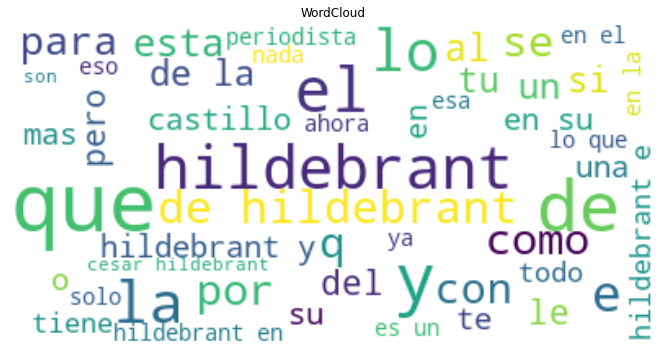

In [294]:
wordcloud = WordCloud(background_color="white", max_font_size=50, max_words=50)
wordcloud = wordcloud.generate(full_text)

plt.figure(figsize=(15,6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title("WordCloud")
plt.show()

In [166]:
text = 'Cuando pienso en el #Periodismo del #Peru, pienso en #Guaripoleras, #Mermelada, #MediaTraining, #Lucar, #Hildebrant, el #Lagarto... 🤢🤢🤢🤢🤢🤮🤮🤮🤮🤮'

In [168]:
get_words_by_key(text, 'U+')

[]

In [ ]:
{
    'q':'que',
    'x':'por'
}

In [162]:
dataset['clean_text'].to_list()[:20]

['Jajaja y lucar q ? Y hildebrant? Jajaj bien payaso eres, canal n también ta comprado por los zurdos',
 'El enano Hildebrant se cree Colon quiere descubrir lo que ya se sabe hace tiempo ...igual nadie compra su Pasquín',
 'Gracias a Hildebrant y sus 13 conocemos la verdad de las cosas, por otros medios seguiríamos viviendo en las mentiras como en los anteriores gobiernos',
 'Que bueno que se reúnan para vaciar a Castillo, Hildebrant creo que ya es hora que te retires',
 'Cuando pienso en el #Periodismo del #Peru, pienso en #Guaripoleras, #Mermelada, #MediaTraining, #Lucar, #Hildebrant, el #Lagarto... 🤢🤢🤢🤢🤢🤮🤮🤮🤮🤮',
 'Ese enano comunista doble cara de cesar hildebrant tiene mujer PITUCA Y DISCRIMINADORA.',
 'Hasta el chato Hildebrant sabe que no se puede pero se inventa ese cuento para los zopencos,tontos útiles d siempre...',
 'Los CONGRESISTAS DEBEN DE UN DENUNCIAR POR DIFAMACION Y CALUMNIA A ESE MONO CON METRALLETA..DENUNCIA TAMBIEN AL CHATO HILDEBRANT Y PEDIR REPARACION CIVIL ESE MUE

In [116]:
dataset['clean_text'] = dataset['text'].apply(get_clean_text)

In [117]:
dataset['clean_text'].apply(get_normalized_text)

0       jajaja y lucar q ? y hildebrant? jajaj bien pa...
1       el enano hildebrant se cree colon quiere descu...
2       gracias a hildebrant y sus 13 conocemos la ver...
3       que bueno que se reunan para vaciar a castillo...
4       cuando pienso en el #periodismo del #peru, pie...
                              ...                        
1129    hildebrant y su mujer basuareando a quienes se...
1130    hildebrant y su mujer basuareando a quienes se...
1131    tampoco fue una reunion secreta para conspirar...
1132    hildebrant y su mujer basuareando a quienes se...
1133    cual es el motivo de filmarlo! de hildebrant f...
Name: clean_text, Length: 1134, dtype: object

In [118]:
dataset['clean_text']

0       Jajaja y lucar q ? Y hildebrant? Jajaj bien pa...
1       El enano Hildebrant se cree Colon quiere descu...
2       Gracias a Hildebrant y sus 13 conocemos la ver...
3       Que bueno que se reúnan para vaciar a Castillo...
4       Cuando pienso en el #Periodismo del #Peru, pie...
                              ...                        
1129    HILDEBRANT Y SU MUJER BASUAREANDO A QUIENES SE...
1130    HILDEBRANT Y SU MUJER BASUAREANDO A QUIENES SE...
1131    Tampoco fue una reunion secreta para conspirar...
1132    HILDEBRANT Y SU MUJER BASUAREANDO A QUIENES SE...
1133    Cuál es el motivo de filmarlo! De Hildebrant f...
Name: clean_text, Length: 1134, dtype: object

In [90]:
text = 'Los CONGRESISTAS DEBEN DE UN DENUNCIAR POR DIFAMACION Y CALUMNIA A ESE MONO CON METRALLETA..DENUNCIA TAMBIEN AL CHATO HILDEBRANT Y PEDIR REPARACION CIVIL ESE MUERTO DE HAMBRE'

In [91]:
text

'Los CONGRESISTAS DEBEN DE UN DENUNCIAR POR DIFAMACION Y CALUMNIA A ESE MONO CON METRALLETA..DENUNCIA TAMBIEN AL CHATO HILDEBRANT Y PEDIR REPARACION CIVIL ESE MUERTO DE HAMBRE'

In [92]:
from wordcloud import WordCloud

In [95]:
wc = WordCloud()

In [89]:
dataset['clean_text'].to_list()

['Jajaja y lucar q ? Y hildebrant? Jajaj bien payaso eres, canal n también ta comprado por los zurdos',
 'El enano Hildebrant se cree Colon quiere descubrir lo que ya se sabe hace tiempo ...igual nadie compra su Pasquín',
 'Gracias a Hildebrant y sus 13 conocemos la verdad de las cosas, por otros medios seguiríamos viviendo en las mentiras como en los anteriores gobiernos',
 'Que bueno que se reúnan para vaciar a Castillo, Hildebrant creo que ya es hora que te retires',
 'Cuando pienso en el #Periodismo del #Peru, pienso en #Guaripoleras, #Mermelada, #MediaTraining, #Lucar, #Hildebrant, el #Lagarto... 🤢🤢🤢🤢🤢🤮🤮🤮🤮🤮',
 'Ese enano comunista doble cara de cesar hildebrant tiene mujer PITUCA Y DISCRIMINADORA.',
 'Hasta el chato Hildebrant sabe que no se puede pero se inventa ese cuento para los zopencos,tontos útiles d siempre...',
 'Los CONGRESISTAS DEBEN DE UN DENUNCIAR POR DIFAMACION Y CALUMNIA A ESE MONO CON METRALLETA..DENUNCIA TAMBIEN AL CHATO HILDEBRANT Y PEDIR REPARACION CIVIL ESE MUE

In [48]:
dataset['mentions']

0            [@Mijail50386462, @j053_4n, @AlvaroVargasLl]
1                                       [@marita_molina4]
2                                          [@sigridbazan]
3                              [@ensustrece, @ensustrece]
4                          [@sabercomo, @julianaoxenford]
                              ...                        
1129                                   [@CynthiaRivarol5]
1130                       [@LaSalitadelSin, @ensustrece]
1131    [@danielyovera, @ANP_periodistas, @ATV, @ensus...
1132                                    [@salvajedigital]
1133                                   [@ValeriaBersaken]
Name: mentions, Length: 1134, dtype: object

In [69]:
dataset

,reply_settings,public_metrics,in_reply_to_user_id,source,conversation_id,referenced_tweets,text,id,lang,created_at,author_id,keyword,timestamp,geo,mentions,hashtags,links
0,everyone,"{'retweet_count': 0, 'reply_count': 1, 'like_c...",1.332811e+18,Twitter for Android,1494431728710164483,"[{'type': 'replied_to', 'id': '149465658079670...",@Mijail50386462 @j053_4n @AlvaroVargasLl Jajaj...,1494719619059363844,es,2022-02-18T17:05:02.000Z,1304877592290504710,hildebrant -is:retweet lang:es,2022-02-18 20:00:35.00,NaN,"[@Mijail50386462, @j053_4n, @AlvaroVargasLl]",[],[]
1,everyone,"{'retweet_count': 0, 'reply_count': 0, 'like_c...",7.189985e+08,Twitter for Android,1494707328653971461,"[{'type': 'replied_to', 'id': '149470732865397...",@marita_molina4 El enano Hildebrant se cree Co...,1494714453128011778,es,2022-02-18T16:44:30.000Z,1062326301292486658,hildebrant -is:retweet lang:es,2022-02-18 20:00:34.20,NaN,[@marita_molina4],[],[]
2,everyone,"{'retweet_count': 0, 'reply_count': 0, 'like_c...",5.479793e+07,Twitter for Android,1492256442631479296,"[{'type': 'replied_to', 'id': '149225644263147...",@sigridbazan Gracias a Hildebrant y sus 13 con...,1492483317312237573,es,2022-02-12T12:58:46.000Z,1566260070,hildebrant -is:retweet lang:es,2022-02-15 08:15:54.81,NaN,[@sigridbazan],[],[]
3,everyone,"{'retweet_count': 0, 'reply_count': 0, 'like_c...",1.248433e+08,Twitter for iPhone,1492149458913615877,"[{'type': 'replied_to', 'id': '149214945891361...",@ensustrece Que bueno que se reúnan para vacia...,1492483056044855297,es,2022-02-12T12:57:44.000Z,139302344,hildebrant -is:retweet lang:es,2022-02-15 08:15:54.81,NaN,"[@ensustrece, @ensustrece]",[],[]
4,everyone,"{'retweet_count': 0, 'reply_count': 0, 'like_c...",7.131398e+07,Twitter for Android,1492324509008994304,"[{'type': 'replied_to', 'id': '149234499162828...",@sabercomo @julianaoxenford Cuando pienso en e...,1492482305448759296,es,2022-02-12T12:54:45.000Z,880745650933174273,hildebrant -is:retweet lang:es,2022-02-15 08:15:54.81,NaN,"[@sabercomo, @julianaoxenford]","[#Periodismo, #Peru,, #Guaripoleras,, #Mermela...",[]
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1129,everyone,"{'retweet_count': 0, 'reply_count': 0, 'like_c...",1.334627e+18,Twitter for Android,1492933301971169282,"[{'type': 'replied_to', 'id': '149293330197116...",@CynthiaRivarol5 HILDEBRANT Y SU MUJER BASUARE...,1492952518875402241,es,2022-02-13T20:03:12.000Z,2988864995,hildebrant -is:retweet lang:es,2022-02-15 08:17:14.40,NaN,[@CynthiaRivarol5],[],[https://t.co/GMA6DTzhye]
1130,everyone,"{'retweet_count': 1, 'reply_count': 0, 'like_c...",7.713518e+17,Twitter for Android,1492689650720325634,"[{'type': 'replied_to', 'id': '149268965072032...",@LaSalitadelSin @ensustrece HILDEBRANT Y SU MU...,1492952116536688648,es,2022-02-13T20:01:36.000Z,2988864995,hildebrant -is:retweet lang:es,2022-02-15 08:17:14.40,NaN,"[@LaSalitadelSin, @ensustrece]",[],[https://t.co/bKosFKFujp]
1131,everyone,"{'retweet_count': 0, 'reply_count': 0, 'like_c...",2.185477e+08,Twitter for Android,1492860146007040004,"[{'type': 'replied_to', 'id': '149286014600704...",@danielyovera @ANP_periodistas @ATV @ensustrec...,1492952022844280832,es,2022-02-13T20:01:14.000Z,1489452548570468357,hildebrant -is:retweet lang:es,2022-02-15 08:17:14.40,NaN,"[@danielyovera, @ANP_periodistas, @ATV, @ensus...",[],[]
1132,everyone,"{'retweet_count': 0, 'reply_count': 0, 'like_c...",6.863815e+07,Twitter for Android,1492944438934577157,"[{'type': 'replied_to', 'id': '149294443893457...",@salvajedigital HILDEBRANT Y SU MUJER BASUAREA...,1492951969870270468,es,2022-02-13T20:01:01.000Z,2988864995,hildebrant -is:retweet lang:es,2022-02-15 08:17:14.40,NaN,[@salvajedigital],[],[https://t.co/f6AQkTLrCf]


<AxesSubplot:>

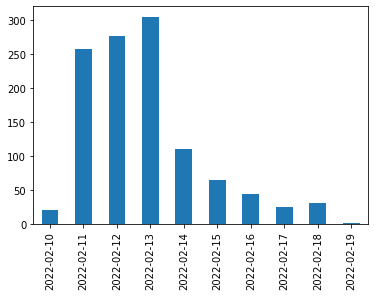

In [68]:
pd.to_datetime(dataset['created_at']).dt.date.value_counts().sort_index().plot(kind='bar')

<AxesSubplot:>

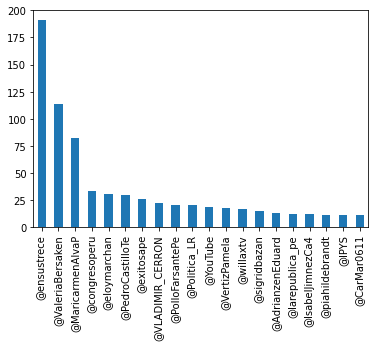

In [59]:
full_list = []
for row in dataset['mentions']:
    full_list += row
    
pd.Series(full_list).value_counts().head(20).plot(kind='bar')

<AxesSubplot:>

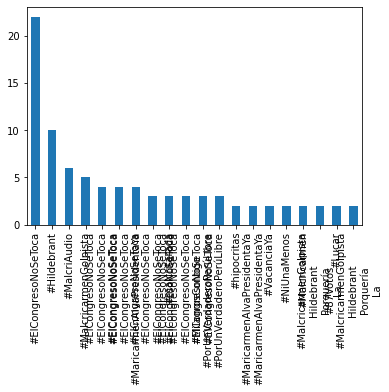

In [60]:
full_list = []
for row in dataset['hashtags']:
    full_list += row
    
pd.Series(full_list).value_counts().head(20).plot(kind='bar')

<AxesSubplot:>

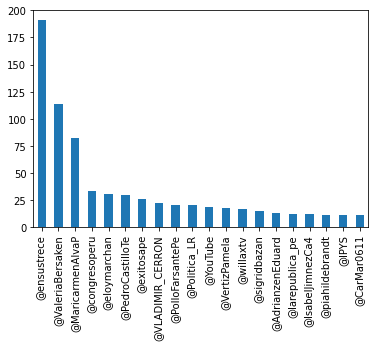

In [27]:
key = 'http'

indexes = [i for i in range(len(text)) if text.startswith(key, i)]
words = [text[x:].split(' ')[0] for x in indexes]
words

['https://t.co/LYWkLJhgyK']

In [21]:
[text[x:].split(' ')[0] for x in indexes]

['#URGENTE', '#Hildebrant']

In [169]:
text = 'ESTE VIERNES EN Hildebrant en sus trece, escucharemos grabaciones de lo tratado en la reunión de congresistas complotadores en el Hotel Miraflores. PORQUE TANTO PEDIDO PARA QUE SE RETIRE LA DENUNCIA CONTRA Alva? Montoya le carga el bolso y C ANDERSON,que? https://t.co/1thSGRRARo'

In [230]:
import inspect

In [ ]:
def get_emojis(text):
    emojis = [x for x in text if x in emoji.UNICODE_EMOJI['en']]
    return emojis

def get_upper_words(text):
    emojis = [x for x in text if x in emoji.UNICODE_EMOJI['en']]
    for emj in emojis:
        text = text.replace(emj, '')
    upper_words = [x.replace(',','') for x in text.split() if (len(x)>2) and (x==x.upper())]
    return upper_words

In [233]:
print(inspect.getsource(get_emojis))

def get_emojis(text):
    emojis = [x for x in text if x in emoji.UNICODE_EMOJI['en']]
    return emojis



In [234]:
print(inspect.getsource(get_upper_words))

def get_upper_words(text):
    emojis = [x for x in text if x in emoji.UNICODE_EMOJI['en']]
    for emj in emojis:
        text = text.replace(emj, '')
    upper_words = [x.replace(',','') for x in text.split() if (len(x)>2) and (x==x.upper())]
    return upper_words



In [227]:
dataset['emojis'] = dataset['text'].apply(get_emojis)
dataset['upper_words'] = dataset['text'].apply(get_upper_words)

In [228]:
dataset['upper_words']

0                                                      []
1                                                      []
2                                                      []
3                                                      []
4                                                      []
                              ...                        
1129    [HILDEBRANT, MUJER, BASUAREANDO, QUIENES, ATRE...
1130    [HILDEBRANT, MUJER, BASUAREANDO, QUIENES, ATRE...
1131                                               [@ATV]
1132    [HILDEBRANT, MUJER, BASUAREANDO, QUIENES, ATRE...
1133                                                   []
Name: upper_words, Length: 1134, dtype: object

In [196]:
import emoji

In [201]:
emoji.UNICODE_EMOJI['en']

4702

In [200]:
[x for x in emoji.UNICODE_EMOJI['en'] if x not in emoji.UNICODE_EMOJI['es']]

['\U0001fad8',
 '\U0001fae6',
 '\U0001fae7',
 '\U0001fab8',
 '💑🏿',
 '💑🏻',
 '👨\u200d❤\u200d👨',
 '👨🏿\u200d❤️\u200d👨🏿',
 '👨🏿\u200d❤\u200d👨🏿',
 '👨🏿\u200d❤️\u200d👨🏻',
 '👨🏿\u200d❤\u200d👨🏻',
 '👨🏿\u200d❤️\u200d👨🏾',
 '👨🏿\u200d❤\u200d👨🏾',
 '👨🏿\u200d❤️\u200d👨🏼',
 '👨🏿\u200d❤\u200d👨🏼',
 '👨🏿\u200d❤️\u200d👨🏽',
 '👨🏿\u200d❤\u200d👨🏽',
 '👨🏻\u200d❤️\u200d👨🏻',
 '👨🏻\u200d❤\u200d👨🏻',
 '👨🏻\u200d❤️\u200d👨🏿',
 '👨🏻\u200d❤\u200d👨🏿',
 '👨🏻\u200d❤️\u200d👨🏾',
 '👨🏻\u200d❤\u200d👨🏾',
 '👨🏻\u200d❤️\u200d👨🏼',
 '👨🏻\u200d❤\u200d👨🏼',
 '👨🏻\u200d❤️\u200d👨🏽',
 '👨🏻\u200d❤\u200d👨🏽',
 '👨🏾\u200d❤️\u200d👨🏾',
 '👨🏾\u200d❤\u200d👨🏾',
 '👨🏾\u200d❤️\u200d👨🏿',
 '👨🏾\u200d❤\u200d👨🏿',
 '👨🏾\u200d❤️\u200d👨🏻',
 '👨🏾\u200d❤\u200d👨🏻',
 '👨🏾\u200d❤️\u200d👨🏼',
 '👨🏾\u200d❤\u200d👨🏼',
 '👨🏾\u200d❤️\u200d👨🏽',
 '👨🏾\u200d❤\u200d👨🏽',
 '👨🏼\u200d❤️\u200d👨🏼',
 '👨🏼\u200d❤\u200d👨🏼',
 '👨🏼\u200d❤️\u200d👨🏿',
 '👨🏼\u200d❤\u200d👨🏿',
 '👨🏼\u200d❤️\u200d👨🏻',
 '👨🏼\u200d❤\u200d👨🏻',
 '👨🏼\u200d❤️\u200d👨🏾',
 '👨🏼\u200d❤\u200d👨🏾',
 '👨🏼\u200d❤️\u200d👨🏽',
 '👨🏼\u200d❤\u200d👨🏽',
 '👨🏽\u

In [178]:
text =  '@sabercomo @julianaoxenford Cuando pienso en el #Periodismo del #Peru, pienso en #Guaripoleras, #Mermelada, #MediaTraining, #Lucar, PADRINO, #Hildebrant, el #Lagarto... 🤢🤢🤢🤢🤢🤮🤮🤮🤮🤮'

In [204]:
words = [x.replace(',','') for x in text.split() if (len(x)>2) and (x==x.upper())]
words

['PADRINO', '🤢🤢🤢🤢🤢🤮🤮🤮🤮🤮']

In [207]:
text

'@sabercomo @julianaoxenford Cuando pienso en el #Periodismo del #Peru, pienso en #Guaripoleras, #Mermelada, #MediaTraining, #Lucar, PADRINO, #Hildebrant, el #Lagarto... 🤢🤢🤢🤢🤢🤮🤮🤮🤮🤮'

In [210]:
[x for x in text[-20:]]

['a',
 'g',
 'a',
 'r',
 't',
 'o',
 '.',
 '.',
 '.',
 ' ',
 '🤢',
 '🤢',
 '🤢',
 '🤢',
 '🤢',
 '🤮',
 '🤮',
 '🤮',
 '🤮',
 '🤮']

In [210]:
[x for x in text[-20:] if ]

['a',
 'g',
 'a',
 'r',
 't',
 'o',
 '.',
 '.',
 '.',
 ' ',
 '🤢',
 '🤢',
 '🤢',
 '🤢',
 '🤢',
 '🤮',
 '🤮',
 '🤮',
 '🤮',
 '🤮']

In [213]:
emoji.UNICODE_EMOJI['en']

{'🥇': ':1st_place_medal:',
 '🥈': ':2nd_place_medal:',
 '🥉': ':3rd_place_medal:',
 '🆎': ':AB_button_(blood_type):',
 '🏧': ':ATM_sign:',
 '🅰️': ':A_button_(blood_type):',
 '🅰': ':A_button_(blood_type):',
 '🇦🇫': ':Afghanistan:',
 '🇦🇱': ':Albania:',
 '🇩🇿': ':Algeria:',
 '🇦🇸': ':American_Samoa:',
 '🇦🇩': ':Andorra:',
 '🇦🇴': ':Angola:',
 '🇦🇮': ':Anguilla:',
 '🇦🇶': ':Antarctica:',
 '🇦🇬': ':Antigua_&_Barbuda:',
 '♒': ':Aquarius:',
 '🇦🇷': ':Argentina:',
 '♈': ':Aries:',
 '🇦🇲': ':Armenia:',
 '🇦🇼': ':Aruba:',
 '🇦🇨': ':Ascension_Island:',
 '🇦🇺': ':Australia:',
 '🇦🇹': ':Austria:',
 '🇦🇿': ':Azerbaijan:',
 '🔙': ':BACK_arrow:',
 '🅱️': ':B_button_(blood_type):',
 '🅱': ':B_button_(blood_type):',
 '🇧🇸': ':Bahamas:',
 '🇧🇭': ':Bahrain:',
 '🇧🇩': ':Bangladesh:',
 '🇧🇧': ':Barbados:',
 '🇧🇾': ':Belarus:',
 '🇧🇪': ':Belgium:',
 '🇧🇿': ':Belize:',
 '🇧🇯': ':Benin:',
 '🇧🇲': ':Bermuda:',
 '🇧🇹': ':Bhutan:',
 '🇧🇴': ':Bolivia:',
 '🇧🇦': ':Bosnia_&_Herzegovina:',
 '🇧🇼': ':Botswana:',
 '🇧🇻': ':Bouvet_Island:',
 '🇧🇷': ':Brazi

In [215]:
emojis

NameError: name 'emojis' is not defined

In [187]:
isinstance('🤢🤢🤢🤢🤢🤮🤮🤮🤮🤮', str)

True

In [190]:
eval('🤮')

SyntaxError: invalid character in identifier (<string>, line 1)

In [189]:
str('🤮')

'🤮'

In [ ]:
[x for x in dataset['text'].to_list() ]

['@Mijail50386462 @j053_4n @AlvaroVargasLl Jajaja y lucar q ? Y hildebrant? Jajaj bien payaso eres, canal n también ta comprado por los zurdos',
 '@marita_molina4 El enano Hildebrant se cree Colon quiere descubrir lo que ya se sabe hace tiempo ...igual nadie compra su Pasquín',
 '@sigridbazan Gracias a Hildebrant y sus 13 conocemos la verdad de las cosas, por otros medios seguiríamos viviendo en las mentiras como en los anteriores gobiernos',
 '@ensustrece Que bueno que se reúnan para vaciar a Castillo, @ensustrece Hildebrant creo que ya es hora que te retires',
 '@sabercomo @julianaoxenford Cuando pienso en el #Periodismo del #Peru, pienso en #Guaripoleras, #Mermelada, #MediaTraining, #Lucar, #Hildebrant, el #Lagarto... 🤢🤢🤢🤢🤢🤮🤮🤮🤮🤮',
 '@nancydenisse67 @ensustrece Ese enano comunista doble cara de cesar hildebrant tiene mujer PITUCA Y DISCRIMINADORA.',
 '@oscardiazperu Hasta el chato Hildebrant sabe que no se puede pero se inventa ese cuento para los zopencos,tontos útiles d siempre...'

In [15]:
dataset = process_json_cols(dataset, print_progress=True)

INFO: Processing Time:	220.91 seconds


In [22]:
dataset['keyword']

0       hildebrant -is:retweet lang:es
1       hildebrant -is:retweet lang:es
2       hildebrant -is:retweet lang:es
3       hildebrant -is:retweet lang:es
4       hildebrant -is:retweet lang:es
                     ...              
1129    hildebrant -is:retweet lang:es
1130    hildebrant -is:retweet lang:es
1131    hildebrant -is:retweet lang:es
1132    hildebrant -is:retweet lang:es
1133    hildebrant -is:retweet lang:es
Name: keyword, Length: 1134, dtype: object

In [20]:
list(dataset)

['reply_settings',
 'in_reply_to_user_id',
 'source',
 'conversation_id',
 'text',
 'id',
 'lang',
 'created_at',
 'author_id',
 'keyword',
 'timestamp',
 'retweet_count',
 'reply_count',
 'like_count',
 'quote_count',
 'type',
 'id_ref',
 'mentions',
 'num_mentions',
 'clean_text',
 'sentiment_output',
 'sentiment_pred',
 'sentiment_conf']

In [18]:
dataset['mentions']

0         [@Mijail50386462, @j053_4n, @AlvaroVargasLl]
1                                    [@marita_molina4]
2                                       [@sigridbazan]
3                           [@ensustrece, @ensustrece]
4                       [@sabercomo, @julianaoxenford]
                             ...                      
1129                                [@CynthiaRivarol5]
1130                    [@LaSalitadelSin, @ensustrece]
1131    [@danielyovera, @ANP_periodistas, @ensustrece]
1132                                 [@salvajedigital]
1133                                [@ValeriaBersaken]
Name: mentions, Length: 1134, dtype: object

<AxesSubplot:>

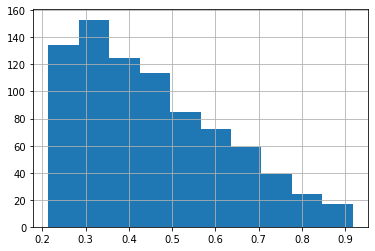

In [8]:
dataset['sentiment_conf'].hist()

In [7]:
# Initialize Sentiment Model
twitter_roberta = 'cardiffnlp/twitter-xlm-roberta-base-sentiment'
sentiment_multi = pipeline(task = 'sentiment-analysis',
                             model = twitter_roberta,
                             tokenizer = twitter_roberta)

ImportError: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html

In [141]:
dataset[['clean_text','sentiment_output']].iloc[4]

clean_text          Gracias a las personas..*Aplaude*
sentiment_output                             5.646634
Name: 4, dtype: object

In [30]:
dataset['clean_text'].to_list()

['Qué les pareció?',
 'Ahora pues https://t.co/G0tax9PNxd',
 'Dos sobones dos chupes 2 caviares UN CAMINO en la emisora del Oficialismo Chavista Atatauuu.. ajjjjjj',
 'a escuchar al gran Cesar H. Con ahorita en vivo',
 'Gracias a las personas..*Aplaude*',
 'Los mismos de ventanilla ni saben que es un distrito del callao 🤣 nadie me lo contó yo lo he visto',
 'Si porque las preguntas que le hicieron Mavila Huertas, Pedro Tenorio y Jaime Chincha no cuentan, porque no son milagros Leiva',
 'LOS RESPONSABLES SON REPSOL Y EL INEPTO DE CASTILLO QUE SE DEMORO EN REACCIONAR! PARA VARIAR ESTANA HACIENDO CUALQUIER COSA MENOS GOBERNAR',
 'Es lo único que saben estos rojos, ahuyentar a los inversionistas sin proponer soluciones.',
 'El detalle Jaime es que intentas emular una suerte de hibrido entre Jaime Bayliy Cesar Hildebrant. Sumado al ego colosal que tienes y es fácil caer en engrandecerse teniendo una generación de periodistas buitres y limitados donde resulta usted es el único que lee o argu

In [ ]:
text

In [9]:
users = data['usersTW_GP__hildebrant.csv']

In [10]:
users

,username,verified,name,id,public_metrics,description,created_at,keyword,timestamp
0,omot_14,False,Omar Ortega Telles,31305297,"{'followers_count': 184, 'following_count': 66...",Finanzas - Universidad del Pacífico. Liberal,2009-04-15T02:04:49.000Z,hildebrant -is:retweet lang:es,2022-02-15 08:15:21.16
1,ToniAlvaL,True,María Antonieta Alva Luperdi,1179864482174119937,"{'followers_count': 573334, 'following_count':...",Servidora pública comprometida con el desarrol...,2019-10-03T21:03:56.000Z,hildebrant -is:retweet lang:es,2022-02-15 08:15:21.16
2,milaoliveros,False,Milagros Oliveros,242803898,"{'followers_count': 758, 'following_count': 18...",NaN,2011-01-25T16:51:32.000Z,hildebrant -is:retweet lang:es,2022-02-15 08:16:57.06
3,unchasqui,False,Un Chasqui del Bicentenario,3700799482,"{'followers_count': 28092, 'following_count': ...",Dizque comunicador con experiencia en radio y ...,2015-09-18T22:13:44.000Z,hildebrant -is:retweet lang:es,2022-02-15 08:16:57.06
4,Alexis74395222,False,Alexis,1302058692947345409,"{'followers_count': 1, 'following_count': 11, ...","Criterio, mucho Criterio.",2020-09-05T01:39:32.000Z,hildebrant -is:retweet lang:es,2022-02-15 08:16:57.06
...,...,...,...,...,...,...,...,...,...
1868,cesaropinion95,False,Cesar M. 🎥🎬📷,394393605,"{'followers_count': 177, 'following_count': 45...",Sobre mí? Un tipo tranquilo y con un extraño s...,2011-10-20T00:40:25.000Z,hildebrant -is:retweet lang:es,2022-02-15 08:15:14.81
1869,luz_amelia18,False,Valeria Rodriguez,833464958436380672,"{'followers_count': 168, 'following_count': 42...",NaN,2017-02-19T23:55:06.000Z,hildebrant -is:retweet lang:es,2022-02-15 08:15:14.81
1870,FedericoPFE,False,Federico Roberto P F,2740119220,"{'followers_count': 640, 'following_count': 93...",la verdad aunque tarde siempre se sabrá. Perua...,2014-08-11T18:03:12.000Z,hildebrant -is:retweet lang:es,2022-02-15 08:15:14.81
1871,fruiz159,False,Fernando Ruiz Inga,292954337,"{'followers_count': 55, 'following_count': 33,...",Especialista en sistemas informaticos para mun...,2011-05-04T14:27:02.000Z,hildebrant -is:retweet lang:es,2022-02-15 08:15:14.81


# Sentiment Analysis

In [11]:
from transformers import pipeline

In [ ]:
pipe = pipeline("sentiment-analysis", model="<your_model_here>", tokenizer="<your_tokenizer_here>")

In [12]:
sa = pipeline('sentiment-analysis')

No model was supplied, defaulted to distilbert-base-uncased-finetuned-sst-2-english (https://huggingface.co/distilbert-base-uncased-finetuned-sst-2-english)


Downloading:   0%|          | 0.00/629 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/255M [00:00<?, ?B/s]

KeyboardInterrupt: 

In [ ]:
sa("We are happy to be in last session of the course")

[{'label': 'POSITIVE', 'score': 0.999824583530426}]

In [ ]:
sa("The movie was really bad")

[{'label': 'NEGATIVE', 'score': 0.99980229139328}]

In [ ]:
sa("I don't mind walking")

[{'label': 'POSITIVE', 'score': 0.7957820296287537}]

In [ ]:
sa_es = pipeline('sentiment-analysis', model="nlptown/bert-base-multilingual-uncased-sentiment")

Downloading:   0%|          | 0.00/953 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/638M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/39.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/851k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

In [ ]:
sa_es("El producto es excelente")

[{'label': '5 stars', 'score': 0.6660403609275818}]

In [ ]:
sa_es("No me gustó mucho la comida")

[{'label': '2 stars', 'score': 0.5694628357887268}]

# Named Entity Recognition

In [ ]:
ner = pipeline("ner")

No model was supplied, defaulted to dbmdz/bert-large-cased-finetuned-conll03-english (https://huggingface.co/dbmdz/bert-large-cased-finetuned-conll03-english)


Downloading:   0%|          | 0.00/998 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.24G [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/60.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/208k [00:00<?, ?B/s]

"""Bitcoin has jumped past $30,000 as Elon Musk said Tesla is "most likely" to start accepting it as payment again."""

In [ ]:
text = """Bitcoin has jumped past $30,000 as Elon Musk said Tesla is "most likely"
          to start accepting it as payment again."""

In [ ]:
[print(r) for r in ner(text)]

{'entity': 'I-PER', 'score': 0.9992423, 'index': 12, 'word': 'El', 'start': 35, 'end': 37}
{'entity': 'I-PER', 'score': 0.9975107, 'index': 13, 'word': '##on', 'start': 37, 'end': 39}
{'entity': 'I-PER', 'score': 0.9971636, 'index': 14, 'word': 'Mu', 'start': 40, 'end': 42}
{'entity': 'I-PER', 'score': 0.9745453, 'index': 15, 'word': '##sk', 'start': 42, 'end': 44}
{'entity': 'I-ORG', 'score': 0.9316861, 'index': 17, 'word': 'Te', 'start': 50, 'end': 52}
{'entity': 'I-ORG', 'score': 0.94788617, 'index': 18, 'word': '##sla', 'start': 52, 'end': 55}


[None, None, None, None, None, None]

In [141]:
dataset['text'].values[-1]

'A los Guaripoleros @DeltaMdelta @JaimeChincha @MavilaHuertasC se le suma @ensustrece con una merme entrevista, luego @NicolasLucar los trolls preparan ya 👏👏👏👏 @EIPeruano @LaSalitadelSin @RecuerdosPeru @eloymarchan @Angelpaezs @jgodoym @TrujiYo https://t.co/gWOQUoIHVg'

In [142]:
text = 'A los Guaripoleros @DeltaMdelta @JaimeChincha @MavilaHuertasC se le suma @ensustrece con una merme entrevista, luego @NicolasLucar los trolls preparan ya 👏👏👏👏 @EIPeruano @LaSalitadelSin @RecuerdosPeru @eloymarchan @Angelpaezs @jgodoym @TrujiYo https://t.co/gWOQUoIHVg'

In [147]:
split = text.split('@')
split

['A los Guaripoleros ',
 'DeltaMdelta ',
 'JaimeChincha ',
 'MavilaHuertasC se le suma ',
 'ensustrece con una merme entrevista, luego ',
 'NicolasLucar los trolls preparan ya 👏👏👏👏 ',
 'EIPeruano ',
 'LaSalitadelSin ',
 'RecuerdosPeru ',
 'eloymarchan ',
 'Angelpaezs ',
 'jgodoym ',
 'TrujiYo https://t.co/gWOQUoIHVg']

In [157]:
[f"@{x.split(' ')[0]}" for x in split if len(x.split(' ')[0]) > 4]

['@DeltaMdelta',
 '@JaimeChincha',
 '@MavilaHuertasC',
 '@ensustrece',
 '@NicolasLucar',
 '@EIPeruano',
 '@LaSalitadelSin',
 '@RecuerdosPeru',
 '@eloymarchan',
 '@Angelpaezs',
 '@jgodoym',
 '@TrujiYo']

In [153]:
len('A los Guaripoleros '.split(' ')[0])

1

In [89]:
[x for x in referenced_tweets if x in dataset]

['id']

In [90]:
[x for x in dataset if x in referenced_tweets]

['id']

In [91]:
[x for x in public_metrics if x in dataset]

['id']

In [92]:
[x for x in dataset if x in public_metrics]

['id']

In [ ]:
[]

In [84]:
dataset['geo'].notnull().sum()

14

In [85]:
dataset

,reply_settings,author_id,public_metrics,conversation_id,referenced_tweets,source,geo,text,in_reply_to_user_id,created_at,lang,id,keyword,timestamp
0,everyone,235917839,"{'retweet_count': 0, 'reply_count': 0, 'like_c...",1484195534588030976,"[{'type': 'replied_to', 'id': '148419553458803...",Twitter for Android,{'place_id': '005bf2190435cf68'},@majo_marcet @MilagrosLeivaG @DeltaMdelta @Mav...,476438821.0,2022-01-20T18:45:11.000Z,es,1484235574705897473,(@JaimeChincha OR Jaime Chincha) -is:retweet l...,2022-01-25 21:47:59.84
1,everyone,1368759646090059776,"{'retweet_count': 0, 'reply_count': 0, 'like_c...",1484234670460088320,"[{'type': 'quoted', 'id': '1484223526286635013'}]",Twitter for Android,NaN,"Ahora pues @CesarAcunaP , @JNJPeru , @Fiscalia...",NaN,2022-01-20T18:41:35.000Z,es,1484234670460088320,(@JaimeChincha OR Jaime Chincha) -is:retweet l...,2022-01-25 21:47:59.84
2,everyone,1448840233097834501,"{'retweet_count': 0, 'reply_count': 0, 'like_c...",1484589027806306306,NaN,Twitter for Android,NaN,@JaimeChincha @ensustrece Dos sobones dos chup...,36477202.0,2022-01-21T18:09:41.000Z,es,1484589027806306306,(@JaimeChincha OR Jaime Chincha) -is:retweet l...,2022-01-25 21:50:09.49
3,everyone,1068223023025700870,"{'retweet_count': 0, 'reply_count': 0, 'like_c...",1484588662901903363,NaN,Twitter for Android,NaN,@RPPNoticias a escuchar al gran Cesar H. Con ...,9075022.0,2022-01-21T18:08:14.000Z,es,1484588662901903363,(@JaimeChincha OR Jaime Chincha) -is:retweet l...,2022-01-25 21:50:09.49
4,everyone,1440036917517578244,"{'retweet_count': 0, 'reply_count': 0, 'like_c...",1484046935128477697,"[{'type': 'replied_to', 'id': '148404693512847...",Twitter for Android,NaN,@JaimeChincha @drhuerta Gracias a las personas...,36477202.0,2022-01-21T18:00:34.000Z,es,1484586735531003905,(@JaimeChincha OR Jaime Chincha) -is:retweet l...,2022-01-25 21:50:09.49
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
817,everyone,51254650,"{'retweet_count': 0, 'reply_count': 0, 'like_c...",1484657587320766464,"[{'type': 'quoted', 'id': '1484341770024488966'}]",Twitter for Android,NaN,A los Guaripoleros @DeltaMdelta @JaimeChincha ...,NaN,2022-01-21T22:42:07.000Z,es,1484657587320766464,(@JaimeChincha OR Jaime Chincha) -is:retweet l...,2022-01-25 21:50:34.05
818,everyone,51254650,"{'retweet_count': 0, 'reply_count': 0, 'like_c...",1484657537425281027,"[{'type': 'quoted', 'id': '1484333501360926723'}]",Twitter for Android,NaN,A los Guaripoleros @DeltaMdelta @JaimeChincha ...,NaN,2022-01-21T22:41:55.000Z,es,1484657537425281027,(@JaimeChincha OR Jaime Chincha) -is:retweet l...,2022-01-25 21:50:34.05
819,everyone,51254650,"{'retweet_count': 0, 'reply_count': 0, 'like_c...",1484657296118620163,"[{'type': 'quoted', 'id': '1484536221120737284'}]",Twitter for Android,NaN,A los Guaripoleros @DeltaMdelta @JaimeChincha ...,NaN,2022-01-21T22:40:57.000Z,es,1484657296118620163,(@JaimeChincha OR Jaime Chincha) -is:retweet l...,2022-01-25 21:50:34.05
820,everyone,51254650,"{'retweet_count': 0, 'reply_count': 0, 'like_c...",1484657180188065796,"[{'type': 'quoted', 'id': '1484558141182382082'}]",Twitter for Android,NaN,A los Guaripoleros @DeltaMdelta @JaimeChincha ...,NaN,2022-01-21T22:40:30.000Z,es,1484657180188065796,(@JaimeChincha OR Jaime Chincha) -is:retweet l...,2022-01-25 21:50:34.05


In [72]:
pd.DataFrame([referenced_tweets])

,type,id,id_ref
0,quoted,1484657099179241472,1484310563475935232


In [39]:
row['public_metrics']

"{'retweet_count': 0, 'reply_count': 0, 'like_count': 0, 'quote_count': 0}"

In [38]:
row

reply_settings                                                  everyone
author_id                                                       51254650
public_metrics         {'retweet_count': 0, 'reply_count': 0, 'like_c...
conversation_id                                      1484657099179241472
referenced_tweets      [{'type': 'quoted', 'id': '1484310563475935232'}]
source                                               Twitter for Android
geo                                                                  NaN
text                   A los Guaripoleros @DeltaMdelta @JaimeChincha ...
in_reply_to_user_id                                                  NaN
created_at                                      2022-01-21T22:40:10.000Z
lang                                                                  es
id                                                   1484657099179241472
keyword                (@JaimeChincha OR Jaime Chincha) -is:retweet l...
timestamp                                         2

In [12]:
dataset['public_metrics']

0      {'retweet_count': 0, 'reply_count': 0, 'like_c...
1      {'retweet_count': 0, 'reply_count': 0, 'like_c...
2      {'retweet_count': 0, 'reply_count': 0, 'like_c...
3      {'retweet_count': 0, 'reply_count': 0, 'like_c...
4      {'retweet_count': 0, 'reply_count': 0, 'like_c...
                             ...                        
817    {'retweet_count': 0, 'reply_count': 0, 'like_c...
818    {'retweet_count': 0, 'reply_count': 0, 'like_c...
819    {'retweet_count': 0, 'reply_count': 0, 'like_c...
820    {'retweet_count': 0, 'reply_count': 0, 'like_c...
821    {'retweet_count': 0, 'reply_count': 0, 'like_c...
Name: public_metrics, Length: 822, dtype: object

In [27]:
for i in dataset['referenced_tweets']:
    try:
        print(len(eval(i)))
    except:
        pass

1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
2
1
1
1
1
1
1
1
1
1
1
1
2
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
2
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1


In [31]:
pd.DataFrame(eval(i))

,type,id
0,quoted,1484310563475935232


In [11]:
list(dataset)

['reply_settings',
 'author_id',
 'public_metrics',
 'conversation_id',
 'referenced_tweets',
 'source',
 'geo',
 'text',
 'in_reply_to_user_id',
 'created_at',
 'lang',
 'id',
 'keyword',
 'timestamp']